In [ ]:
!pip install -q datasets faiss-gpu transformers sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
# prompt: login to huggingface

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from datasets import load_dataset
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer, AutoProcessor, AutoModelForPreTraining
import faiss
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Embedding

In [ ]:
# Load CLIPProcessor and CLIPTokenizer

clip_model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

In [ ]:
dataset = ds["train"]
ds_with_embeddings = dataset.map(
    lambda example: {
        "text_embedding": clip_model.get_text_features(
            **clip_tokenizer([example["image_description"]], truncation=True, return_tensors="pt").to("cuda")
        )[0]
        .detach()
        .cpu()
        .numpy()
    }
)

ds_with_embeddings = ds_with_embeddings.map(
    lambda example: {
        "image_embedding": clip_model.get_image_features(**clip_processor([example["image"]], return_tensors="pt").to("cuda"))[
            0
        ]
        .detach()
        .cpu()
        .numpy()
    }
)

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [ ]:
ds_with_embeddings = ds_with_embeddings.map(
    lambda example: {
        "combined_embedding": np.concatenate(
            (example["text_embedding"], example["image_embedding"])
        )
    }
)

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [ ]:
# create FAISS index for text embeddings
ds_with_embeddings.add_faiss_index(column="combined_embedding")

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'text_embedding', 'image_embedding', 'combined_embedding'],
    num_rows: 2340
})

In [ ]:
def downscale_images(image):
    width = 200
    ratio = width / float(image.size[0])
    height = int((float(image.size[1]) * float(ratio)))
    img = image.resize((width, height), Image.Resampling.LANCZOS)
    return img

In [ ]:
def perform_faiss_retrieval(user_query, user_image):
  user_query_embedding = clip_model.get_text_features(**clip_tokenizer([user_query], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
  user_image_embedding = clip_model.get_image_features(**clip_processor([user_image], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
  concatenated_embedding = np.concatenate((user_query_embedding, user_image_embedding))
  scores, retrieved_examples = ds_with_embeddings.get_nearest_examples("combined_embedding", concatenated_embedding, k=1)
  return retrieved_examples["image_description"], retrieved_examples["image"]

# Retrieval and augmentation

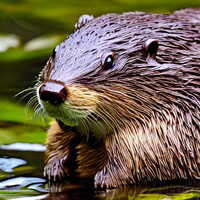

In [ ]:
import requests

user_query = "a snowman"
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/beaver.png"
user_image = Image.open(requests.get(url, stream=True).raw)
display(downscale_images(user_image))

In [ ]:
from transformers import AutoModelForVision2Seq

# 1. Retrieve relevant image and text using FAISS
retrieved_text, retrieved_image = perform_faiss_retrieval(user_query, user_image)

# 2. Prepare input for Llama
combined_text = f"User query: {user_query}\nRelevant information: {retrieved_text}"

# 3. Load and use the Llama model
model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForVision2Seq.from_pretrained(model_name)

inputs = processor(text=combined_text, images=retrieved_image, return_tensors="pt")

generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_text)

Unused or unrecognized kwargs: truncation.


preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

ValueError: The checkpoint you are trying to load has model type `mllama` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.